# Analysis 2
- Outcome: SCC in 5 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
model = 'logreg'
cancer = 'ESCC'
ro.globalenv['cancer'] = cancer

analysis_num = '2'

In [8]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), "_5yr")

In [9]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
model_filename = f'{model}_{cancer}.rds'

In [10]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['model_filename'] = model_filename

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [13]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000013,0.000007,0.000022,0.000000e+00
2,race_clean.(Intercept),race_clean,(Intercept),0.000017,0.000009,0.000029,8.135429e-291
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000021,0.000013,0.000033,0.000000e+00
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.145539,0.023185,0.501022,9.524518e-03
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000012,0.000007,0.000019,0.000000e+00
11,alcohol_binary.alcohol_binary1,alcohol_binary,1,2.555615,1.161543,5.393266,1.531699e-02
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000014,0.000009,0.000021,0.000000e+00
14,hpylori_active_chronic_binary.(Intercept),hpylori_active_chronic_binary,(Intercept),0.000016,0.000011,0.000023,0.000000e+00
16,hnca.(Intercept),hnca,(Intercept),0.000014,0.000009,0.000021,0.000000e+00
17,hnca.hnca1,hnca,1,33.664656,8.012544,95.958017,8.721165e-09


## Feature selection

In [16]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

[1] "ethnicity"      "alcohol_binary" "hnca"           "gerd"          
[5] "cad"            "famhx_cancer"   "PPI"            "age"           


### Forest plot for univariate visualization

In [17]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

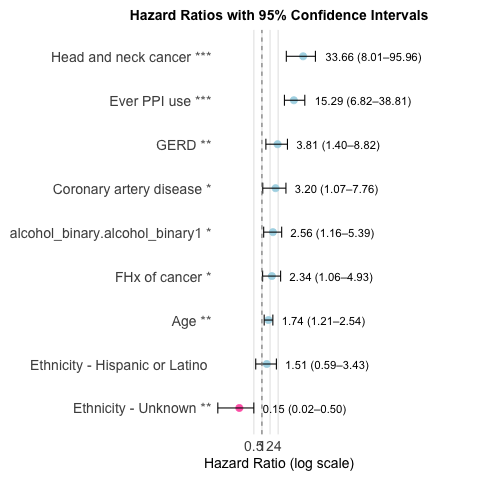

In [18]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [19]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 34155" "Dataset Cases 28"      
[1] "Training Controls 27328" "Training Cases 19"      
[1] "Validation Controls 6827" "Validation Cases 9"      



#### Multivariate analysis

In [20]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2_ESCC.csv 


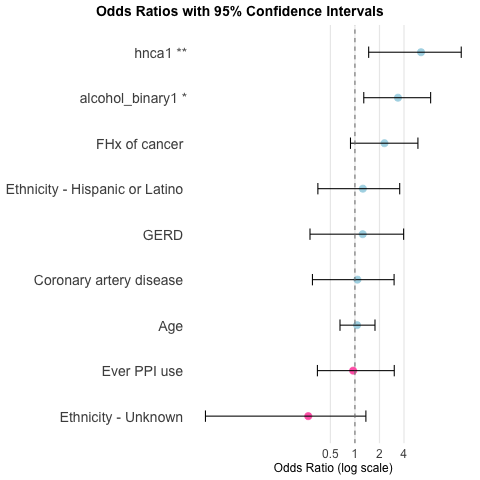

In [21]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [22]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [23]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [24]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.62 
Sensitivity: 0.6666667 
Specificity: 0.7004541 
PPV: 0.002925402 
NPV: 0.999373 
NNS: 435.0771 
     predicted_class
event    0    1
    0 4782 2045
    1    3    6


### Sensitivity and Metrics at threshold that maximizes Youdens

In [25]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.62 
Sensitivity: 0.6666667 
Specificity: 0.700747 
PPV: 0.002928258 
NPV: 0.9993733 
NNS: 434.4878 
     predicted_class
event    0    1
    0 4784 2043
    1    3    6


### AUROC curves and PR curve

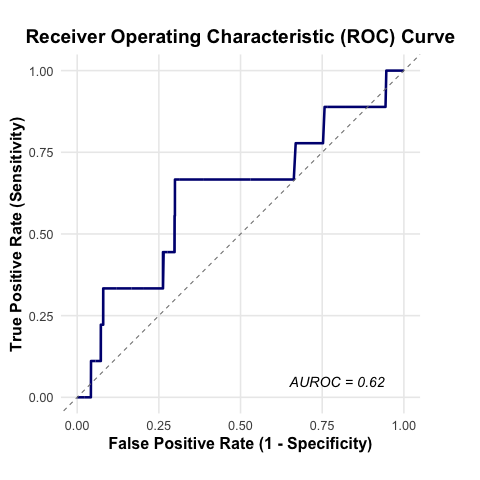

In [26]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

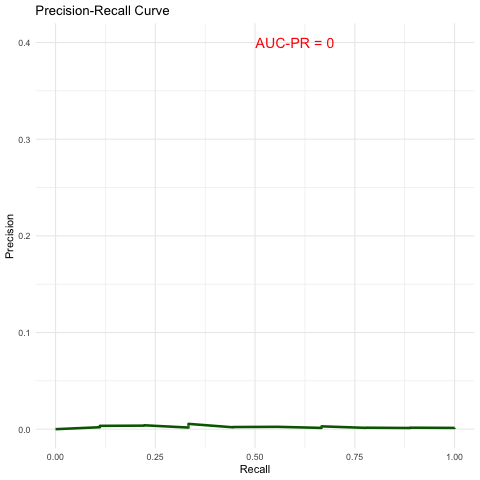

In [27]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [28]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [29]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.7,risk_p0.7002633118782914,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000102,0.107958,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000119,0.163107,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001364,0.910767,0.90,1,1,1,1,1,1,1,1,0,0,0,0,1,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000479,0.672030,0.60,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002895,0.963868,0.95,1,1,1,1,1,1,1,1,1,0,0,0,0,1


In [30]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", 'ugica_5yr', race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", 'ugica_5yr', sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", 'ugica_5yr', age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", 'ugica_5yr', visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [31]:
df_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ugica_5yr,70-79,1953,7,556,5 (0.9%),0.9,5,551,2,1402,0.717857,0.282143,71.428571,71.786994,0.899281,99.857550,132.129993,0.432156
71,high_risk_youden,youden,ugica_5yr,50-59,1262,9,397,5 (1.3%),1.3,5,392,4,870,0.688434,0.311566,55.555556,68.938193,1.259446,99.542334,124.722502,0.244937
72,high_risk_youden,youden,ugica_5yr,2011-2014,2857,11,950,8 (0.8%),0.8,8,942,3,1915,0.670502,0.329498,72.727273,67.028351,0.842105,99.843587,145.838002,0.397556
73,high_risk_youden,youden,ugica_5yr,2015-2018,2274,26,701,16 (2.3%),2.3,16,685,10,1589,0.697826,0.302174,61.538462,69.876869,2.282454,99.374609,60.347744,0.314153
74,high_risk_youden,youden,ugica_5yr,2019-2022,1665,3,398,3 (0.8%),0.8,3,395,0,1270,0.763189,0.236811,100.000000,76.276276,0.753769,100.000000,132.666667,0.762763


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [32]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
3,risk_p0.5,0.5,cgc_5yr,all,6825,11,3398,11 (0.3%),0.3,11,3387,0,3438,0.504535,0.495465,100.000000,50.373626,0.323720,100.000000,308.909091,0.503736
8,risk_p0.6,0.6,cgc_5yr,all,6825,11,2732,10 (0.4%),0.4,10,2722,1,4103,0.601668,0.398332,90.909091,60.117216,0.366032,99.975634,292.683721,0.510263
13,risk_p0.7,0.7,cgc_5yr,all,6825,11,2051,8 (0.4%),0.4,8,2043,3,4782,0.700702,0.299298,72.727273,70.065934,0.390054,99.937304,305.476235,0.427932
58,risk_p0.7002633118782914,0.700263,cgc_5yr,all,6825,11,2049,8 (0.4%),0.4,8,2041,3,4784,0.700995,0.299005,72.727273,70.095238,0.390434,99.937330,305.096986,0.428225
18,risk_p0.75,0.75,cgc_5yr,all,6825,11,1693,5 (0.3%),0.3,5,1688,6,5137,0.752194,0.247806,45.454545,75.267399,0.295334,99.883337,559.690107,0.207219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_5yr,all,6796,40,683,8 (1.2%),1.2,8,675,32,6121,0.896577,0.103423,20.000000,90.067687,1.171303,99.479928,153.555210,0.100677
35,risk_p0.95,0.95,ugica_5yr,all,6796,40,342,4 (1.2%),1.2,4,338,36,6458,0.945290,0.054710,10.000000,95.026486,1.169591,99.445642,162.540105,0.050265
40,risk_p0.975,0.975,ugica_5yr,all,6796,40,171,2 (1.2%),1.2,2,169,38,6627,0.969719,0.030281,5.000000,97.513243,1.169591,99.429857,166.820111,0.025132
45,risk_p0.99,0.99,ugica_5yr,all,6796,40,69,1 (1.4%),1.4,1,68,39,6728,0.984348,0.015652,2.500000,98.999411,1.449275,99.423674,114.554220,0.014994


In [33]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [34]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [35]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    cancer: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
